Installing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("train.csv")         # Train csv Data loading 
print(df.head)                        # Printing first few rows 

<bound method NDFrame.head of       essay_id                                          full_text  score
0      000d118  Many people have car where they live. The thin...      3
1      000fe60  I am a scientist at NASA that is discussing th...      3
2      001ab80  People always wish they had the same technolog...      4
3      001bdc0  We all heard about Venus, the planet without a...      4
4      002ba53  Dear, State Senator\n\nThis is a letter to arg...      3
...        ...                                                ...    ...
17302  ffd378d  the story " The Challenge of Exploing Venus " ...      2
17303  ffddf1f  Technology has changed a lot of ways that we l...      4
17304  fff016d  If you don't like sitting around all day than ...      2
17305  fffb49b  In "The Challenge of Exporing Venus," the auth...      1
17306  fffed3e  Venus is worthy place to study but dangerous. ...      2

[17307 rows x 3 columns]>


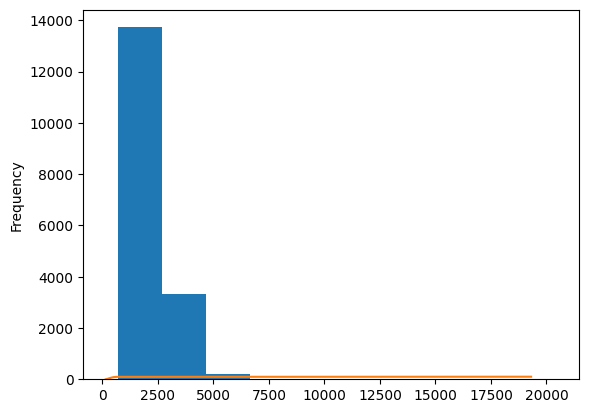

[  148.   179.   200.   219.   237.   255.   274.   292.   310.   328.
   349.   367.   387.   407.   431.   457.   486.   523.   572.   664.
 19311.]


<module 'matplotlib.pyplot' from '/home/codespace/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [4]:
df.columns     # checking the distribution
# df["score"].value_counts().plot.bar()  
df["full_text"].str.len().plot.hist()    

length_word=[len(i.split(" ")) for i in df["full_text"]]
length_word.sort(reverse=True)
percentile_range=range(0,101,5)
x_axis=np.percentile(length_word,percentile_range)
plt.plot(x_axis,percentile_range)
plt.show()
print(x_axis)
#print(np.percentile(length_word,100))

plt

Tokenizing the dataset

In [5]:
!pip install sentencepiece  

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.3 MB/s eta 0:00:0000:0100:010m

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
import sentencepiece as spm
# Using sentencepiece

def prepare_data(df, column_name, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        for text in df[column_name]:
            f.write(text + '\n')

prepare_data(df, 'full_text', 'essays.txt')





def train_sentencepiece(input_file, model_prefix, vocab_size=8000, model_type='bpe'):
    spm.SentencePieceTrainer.train(
        input=input_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type=model_type,
        character_coverage=1.0,
        pad_id=0,
          unk_id=1,
        bos_id=2,
        eos_id=3,
        pad_piece='[PAD]',
        unk_piece='[UNK]',
        bos_piece='[BOS]',
        eos_piece='[EOS]'
    )

train_sentencepiece('essays.txt', 'essay_sp', vocab_size=8000)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: essays.txt
  input_format: 
  model_prefix: essay_sp
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: [UNK]
  bos_piece: [BOS]
  eos_piece: [EOS]
  pad_piece: [PAD]
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_p

In [7]:

sp = spm.SentencePieceProcessor()


sp.load('essay_sp.model')



#encoded_essays = [sp.encode(i for i in df["full_text"])]



def essay_encoder(df,encoder_model,max_len=500):
    failsafe=0
    encoded_df=[]
    for i in df:
        encoded_text=encoder_model.encode(i)
        if len(encoded_text)>=max_len:
            encoded_text=encoded_text[:max_len]
        if len(encoded_text)<max_len:
            encoded_text=np.pad(encoded_text,(0,max_len-len(encoded_text)))
        encoded_df.append(encoded_text)
    return encoded_df
       
        
          


encoded_data=np.array(essay_encoder(df["full_text"],sp,max_len=500))
normalized_scores=df["score"]/6
#print("hi"+sp.decode([0])+"helo")


Splitting of data

In [8]:
#  doing 70,15,15 split 
tsplit_len=int(0.7*len(encoded_data))
tvsplit_len=int(0.15*len(encoded_data))
x_train=encoded_data[:tsplit_len]
x_test=encoded_data[tsplit_len:tvsplit_len+tsplit_len]
x_val=encoded_data[tsplit_len+tvsplit_len:]

y_train=normalized_scores[:tsplit_len]
y_test=normalized_scores[tsplit_len:tvsplit_len+tsplit_len]
y_val=normalized_scores[tsplit_len+tvsplit_len:]
# print(len(df["full_text"]),len(x_train)+len(x_test)+len(x_val),len(y_train)+len(y_test)+len(y_val))

Making Model

In [11]:
import tensorflow as tf
from tensorflow import keras
@tf.keras.utils.register_keras_serializable()

def make_model(vocab_size, embedding_dim,max_length,rnn_units=64):
    model=keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_length),
        keras.layers.Bidirectional(keras.layers.LSTM(rnn_units, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(rnn_units)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ]
    )
    return model


model=make_model(vocab_size=8000,embedding_dim=64,max_length=500,rnn_units=64)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


2024-06-30 13:47:28.694051: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 13:47:28.840536: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 13:47:28.889297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 13:47:28.933885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 13:47:28.933933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 13:47:29.017440: I tensorflow/core/platform/cpu_feature_guard.cc:

Summary of our model

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training of model

In [13]:
model.fit(x_train,y_train,epochs=1,batch_size=64, validation_data=(x_val,y_val),callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])


2024-06-30 13:49:19.491954: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48456000 exceeds 10% of free system memory.


190/190 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - loss: 0.0468 - mae: 0.1579 - val_loss: 0.0196 - val_mae: 0.1132


Predicting Model data

In [14]:
#test_loss, test_mae = model.evaluate(x_test, y_test)
#print(f"Test MAE: {test_mae}")
prediction=model.predict(x_test)

#print("actual_score=",y_test[0],"Predicted_score=",predection[0]*6)

82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step


Function to convert normal text into Model Input

In [15]:
def encode_input(text,encoder_model,max_len=500):
    text=encoder_model.encode(text)
    if len(text)>=max_len:
            text=text[:max_len]
    if len(text)<max_len:
        text=np.pad(text,(0,max_len-len(text)))
    return np.array(text)


Showing full text

In [16]:
df["full_text"][8000]

'Cars have been used for a very long time now and are a revolutionary invention that completely changed the way humans lived, since it became easier to move from one place to another and increase the size of our cities and mobility in general. Automobiles have alwayas been extremly useful and necesary to our society, however, it had too, some significant disadvantages that could have great impact on our lives. Having this clear now we can point ouit tghe advantages of limiting the car usage no matter how hard or difficult it might be to the biggest cities or more developed societies.\n\nIt is important to notice an experiment that was conducted in Germany, the city of Vauban was finished in 2006 and it is an example of a "car-free" environment with a few exceptions such as the main street and borders, acording to Elizabeth Rosenthal in her article: "In German Suburbs, Life Goes On Without Cars". In the passage it is explained how people gave up a certain lifesctyle to participate in th

Empty String Passing

In [17]:
essay_string = """ """       

Passing any String

In [18]:
essay_string = """This is the Machine Learning Model"""

Using encoder to encode the string into vectors

In [19]:
encoded_user_input = encode_input(essay_string,sp,max_len=500)

In [20]:
encoded_user_input=encoded_user_input.reshape(1,500)
user_input_prediction = model.predict(encoded_user_input)
print("Score = ",((user_input_prediction)*6))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Score =  [[1.3151681]]


Checking the Actual Score and Predicted Score

In [21]:
print("Actual Score =",list(y_test[0:1]*6),"Predicted Score=", np.round(prediction[0]*6))

Actual Score = [2.0] Predicted Score= [2.]


Saving the model

In [22]:

model.save("model.keras")

Loading the model

In [23]:

model1 = keras.models.load_model("model.keras")

In [24]:
print(model1.predict(encoded_user_input)*6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
[[1.3151681]]


Multiplying by 6 to get the score from range 1 to 6

In [25]:
for i in range(25):
    print("Actual score=",list(y_test[i:i+1]*6),"Predicted score=",np.round(prediction[i]*6))

Actual score= [2.0] Predicted score= [2.]
Actual score= [2.0] Predicted score= [3.]
Actual score= [5.0] Predicted score= [3.]
Actual score= [5.0] Predicted score= [4.]
Actual score= [3.0] Predicted score= [2.]
Actual score= [4.0] Predicted score= [2.]
Actual score= [3.0] Predicted score= [3.]
Actual score= [5.0] Predicted score= [3.]
Actual score= [2.0] Predicted score= [2.]
Actual score= [2.0] Predicted score= [3.]
Actual score= [4.0] Predicted score= [3.]
Actual score= [6.0] Predicted score= [4.]
Actual score= [3.0] Predicted score= [3.]
Actual score= [3.0] Predicted score= [3.]
Actual score= [2.0] Predicted score= [2.]
Actual score= [1.0] Predicted score= [2.]
Actual score= [4.0] Predicted score= [4.]
Actual score= [2.0] Predicted score= [3.]
Actual score= [5.0] Predicted score= [4.]
Actual score= [2.0] Predicted score= [3.]
Actual score= [3.0] Predicted score= [2.]
Actual score= [4.0] Predicted score= [3.]
Actual score= [3.0] Predicted score= [2.]
Actual score= [3.0] Predicted scor

In [26]:
print(encoded_data.shape)
#print(normalized_scores[:100])

print(prediction.shape,y_test.shape)
print(prediction[0])
# mod(optimizer='adam', loss='mean_squared_error', metrics=['mae'])el.compile 


(17307, 500)
(2596, 1) (2596,)
[0.38234502]
